# INFORMATION PLANE

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture # <-- Using sklearn for GMMs
from scipy.special import logsumexp # For GMM entropy calculation (though score_samples is used)
from typing import List
import collections
from scipy.stats import norm

# Helpers

In [2]:
import time
import pandas as pd
class Timer(object):
    def __init__(self):
        self.last_time = time.time()
        self.dct = {}

    def add(self, name):
        if not name in self.dct.keys():
            self.dct[name] = []
        cur_time = time.time()
        self.dct[name].append(cur_time - self.last_time)
        self.last_time = cur_time

    def report(self)->pd.DataFrame:
        result_dct = {'name': [], 'count': [], 'total': []}
        for name, values in self.dct.items():
            result_dct['name'].append(name)
            result_dct['total'].append(np.sum(values))
            result_dct['count'].append(len(values))
        return pd.DataFrame(result_dct)
        
        
# TESTS
timer = Timer()
timer.add('first')
time.sleep(1)
timer.add('second')
timer.add('first')
timer.add('second')
df = timer.report()
assert(isinstance(df, pd.DataFrame))
assert(df.loc[0, 'total'] < 0.1)
assert(df.loc[1, 'total'] > 1)
print("OK!")

OK!


In [3]:
def calculateNormalPdf(x, mu, sigma):
    """
    Calculates the probability density function (PDF) of a normal distribution.

    Args:
        x (numpy.ndarray or float): The value(s) at which to evaluate the PDF.
        mu (float): The mean of the normal distribution.
        sigma (float): The standard deviation of the normal distribution.

    Returns:
        numpy.ndarray or float: The probability density at x.
    """
    if sigma <= 0:
        raise ValueError("Standard deviation (sigma) must be positive.")

    coefficient = 1 / (sigma * np.sqrt(2 * np.pi))
    exponent = -((x - mu)**2) / (2 * sigma**2)
    pdf_value = coefficient * np.exp(exponent)
    return pdf_value

# Tests
prob = np.sum([calculateNormalPdf(-n/100, 0, 1) for n in range(1, 5000)])/100
assert((0.5 - prob) < 0.01)
print("OK!")

OK!


In [4]:
def calculateNormalEntropy(mu:float, sigma:float)->float:
    """
    Calculates the entropy of a sample from the normal distribution
    """
    # expected_entropy = 1/2*np.log2(2*np.pi*np.e*sigma)
    num_sample = 100
    # Range of the x-axis
    range_arr =  np.linspace(mu - 5*sigma, mu + 5*sigma, num_sample)
    dx = np.mean(np.diff(range_arr))
    pdf_arr = norm.pdf(range_arr, loc=mu, scale=sigma)
    return -np.sum([x*np.log2(x)*dx for x in pdf_arr])

# Tests
calculateNormalEntropy(0, 1)

2.0470863686536873

In [5]:
from scipy.stats import norm

num_sample = 10000
mu = 0
sigma = 1
range_arr =  np.linspace(mu - 5*sigma, mu + 5*sigma, num_sample)
pdf_arr = norm.pdf(range_arr, loc=mu, scale=sigma)
dx = 10*sigma/num_sample
sum(x*dx for x in pdf_arr)

0.9998994282396685

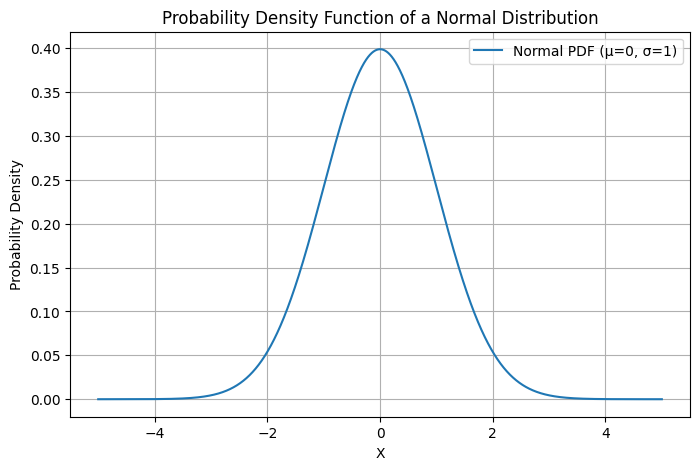

In [6]:

# Plot the PDF
plt.figure(figsize=(8, 5))
plt.plot(range_arr, pdf_arr, label=f'Normal PDF (μ={mu}, σ={sigma})')
plt.title('Probability Density Function of a Normal Distribution')
plt.xlabel('X')
plt.ylabel('Probability Density')
plt.grid(True)
plt.legend()
plt.show()

# Code from Gemini

## generate_synthetic_data

In [17]:
# --- 1. Synthetic Data Generation ---
def generate_synthetic_data(num_samples, slope, intercept, noise_std, classification_threshold):                                                            
    """ 
    Generates synthetic data for a binary classification task.
    Input X: Uniform(0, 1)
    Continuous Y: slope * X + intercept + Gaussian_noise
    Binary Y: 1 if Continuous Y > classification_threshold, else 0
    """
    X = np.random.uniform(0, 1, num_samples)
    noise = np.random.normal(0, noise_std, num_samples)
    Y_continuous = slope * X + intercept + noise
    Y_binary = (Y_continuous > classification_threshold).astype(int)

    # Reshape for PyTorch compatibility (add feature dimension)
    X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
    Y_tensor = torch.tensor(Y_binary, dtype=torch.float32).unsqueeze(1)
    return X_tensor, Y_tensor, X, Y_binary # Return numpy arrays for MI estimation


### generateMixture

In [60]:
# --- 1. Synthetic Data Generation ---
def generateMixture(num_sample:List[int], means:List[float], stds:List[float], num_dim=2, noise:float=0.8)->np.ndarray:
    """
    Generates synthetic data for a binary classification task. 

    Args:
        num_sample (int): number of samples in the n-th mixture
        means (float): mean of the n-th mixture
        std (float): standard deviation of the n-th mixture
    Returns:
        np.array (num_sample, 1), int. total count is = sum(num_samples)
    """
    results = [np.random.normal(m, s, n) for n, m, s in zip(num_sample, means, stds)]
    merged_arr = np.concatenate(results)
    data_arr = np.random.permutation(merged_arr).reshape(-1, 1)
    # Add the other dimensions
    arrs = [data_arr]
    num_total = sum(num_sample)
    for _ in range(num_dim - 1):
        noise_arr = np.random.normal(0, noise, num_total)
        arrs.append(arrs[0] + noise_arr)
    if num_dim > 1:
        arr = np.array(arrs)
        arr = np.reshape(arr, num_sample, num_dim)
    else:
        arr = data_arr
    import pdb; pdb.set_trace()
    return arr
                    

# Tests
precision = 2
num_sample1 = 3
small_mean = 0.1
arr = generateMixture([num_sample1, 5], (small_mean, 100), (.01, 10), num_dim=1)
assert(np.ndim(arr) == 2)
assert(np.sum(arr < 10*small_mean)) == num_sample1
print("OK!")

> /var/folders/02/lb248q1j50dch2pthzkvxmpr0000gn/T/ipykernel_70431/2841607296.py(28)generateMixture()
     26         arr = data_arr
     27     import pdb; pdb.set_trace()
---> 28     return arr
     29 
     30 



ipdb>  np.shape(arr)


(8, 1)


ipdb>  exit


### SimpleNN

In [8]:
# --- 2. Neural Network Architecture ---
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(SimpleNN, self).__init__()
        layers = []
        # Store activations *after* ReLU for Information Plane
        self.linear_layers = nn.ModuleList()
        self.relu_layers = nn.ModuleList()

        # Input layer to first hidden layer
        self.linear_layers.append(nn.Linear(input_dim, hidden_dims[0]))
        self.relu_layers.append(nn.ReLU())

        # Hidden layers. Specifying the dimensions for each layer.
        for i in range(len(hidden_dims) - 1):
            self.linear_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            self.relu_layers.append(nn.ReLU())

        # Output layer (no ReLU before sigmoid)
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        self.sigmoid = nn.Sigmoid()

        self.activations = {} # To store activations for information plane

    def forward(self, x):
        # Store input x for I(X;T)
        self.activations['input'] = x.detach().cpu().numpy()
        current_activation = x
        for i, (linear_layer, relu_layer) in enumerate(zip(self.linear_layers, self.relu_layers)):
            current_activation = linear_layer(current_activation)
            current_activation = relu_layer(current_activation)
            # Store the activation after ReLU
            self.activations[f'hidden_{i}'] = current_activation.detach().cpu().numpy()

        output = self.output_layer(current_activation)
        output = self.sigmoid(output)
        return output

### calculateEntropy

In [9]:
MixtureCalculation = collections.namedtuple("MixtureCalculation",
        ["Hx", "variate_arr", "pdf_arr", "dx"])
def calculateGaussianMixtureEntropy(means:List[float], stds:List[float], weights:List[float]
        )->MixtureCalculation:
    """
    Uses the normal distribut to calculate the expected entropy of a guassian mixture.

    Args:
        means: distribution of the means
        stds: variances of the distributions
        weights: weight of component

    Returns:
        float - entropy
    """
    NUM_POINT =1000
    EXTREME_SIGMA = 4
    mean_arr = np.array(means)
    std_arr = np.array(stds)
    weight_arr = np.array(weights)
    #
    # Calculate the range for the x-variate
    lower_bound = min([m - EXTREME_SIGMA*s for m, s in zip(mean_arr, std_arr)])
    upper_bound = max([m + EXTREME_SIGMA*s for m, s in zip(mean_arr, std_arr)])
    variate_arr = np.linspace(lower_bound, upper_bound, NUM_POINT)
    dx = np.mean(np.diff(variate_arr))
    # Calculate the PDFs
    pdf_arr = np.zeros(NUM_POINT)
    for mean, std, weight in zip(mean_arr, std_arr, weight_arr):
        pdf_arr += weight*norm.pdf(variate_arr, loc=mean, scale=std)
    # Entropy
    Hx = -sum(pdf_arr*np.log2(pdf_arr))*dx
    #
    return MixtureCalculation(Hx=Hx, variate_arr=variate_arr, pdf_arr=pdf_arr, dx=dx)

# Tests
#   Guassian
for std in [1, 2, 4, 8]:
    actual = 0.5*np.log2(2*np.pi*np.e*std**2)
    estimated = calculateGaussianMixtureEntropy([0], [std], [1]).Hx
    #print(actual, estimated)
    assert(np.abs(actual - estimated) < 0.01)
#   Change in mean
estimate1 = calculateGaussianMixtureEntropy([0, 1], [4, 4], [0.5, 0.5]).Hx
estimate2 = calculateGaussianMixtureEntropy([0, 4], [4, 4], [0.5, 0.5]).Hx
#print(estimate1, estimate2)
assert(estimate1 < estimate2)
#   Change in std
estimate1 = calculateGaussianMixtureEntropy([0, 1], [4, 4], [0.5, 0.5]).Hx
estimate2 = calculateGaussianMixtureEntropy([0, 1], [4, 16], [0.5, 0.5]).Hx
#print(estimate1, estimate2)
assert(estimate1 < estimate2)
print("OK!")

OK!


In [10]:
Mixture = collections.namedtuple("Mixture", ["gmm", "Hx", "pdf_arr", "variate_arr", "dx"])
def calculateMixture1d(sample_arr, num_component:int=3)->Mixture:
    """
    Calculates a guassian mixture distribution for 1d sample.

    Args:
        sample_arr: array of one dimensional variates
        num_component (int): number of components used in the GMM

    Returns:
        Mixture:
            gmm: GausianMixture gitted object
            Hx: differential entropy
            variate_arr: values on x-axis
            pdf_arr: density
            dx (float): change in x values in calculation
    """
    EXTREME_SIGMA = 4
    gmm = GaussianMixture(n_components=num_component, random_state=42, covariance_type='diag')
    gmm.fit(sample_arr)
    std_arr = np.sqrt(gmm.covariances_.flatten())
    mean_arr = np.reshape(gmm.means_, num_component)
    weight_arr = gmm.weights_
    # Calculate entropy
    result = calculateGaussianMixtureEntropy(mean_arr, std_arr, weight_arr)
    # Calculate the range for the x-variate
    #
    return Mixture(gmm=gmm, Hx=result.Hx, pdf_arr=result.pdf_arr, variate_arr=result.variate_arr,
            dx=result.dx)

# Tests
num_point = 1000
sigmas = [1, 2, 4]
num_component = len(sigmas)
sample_arr = generateMixture([10*num_point]*num_component, 10*np.array(range(num_component)), sigmas)
result = calculateMixture1d(sample_arr)
assert(isinstance(result.gmm, GaussianMixture))
print("OK!")

OK!


### estimate_mi_gmm

In [11]:
# --- 3. GMM-based Mutual Information Estimation ---

def estimate_mi_gmm(X_samples, T_samples, n_components=5, cov_type='full', random_state=None):
    """
    Estimates Mutual Information I(X; T) using Gaussian Mixture Models.
    X_samples (numpy.ndarray): Input data (e.g., X).
    T_samples (numpy.ndarray): Layer activations (e.g., T).
    Both are treated as continuous variables.
    """
    X_samples = np.asarray(X_samples)
    T_samples = np.asarray(T_samples)

    # Ensure X_samples and T_samples have at least 2 dimensions for GMM if they are 1D
    if X_samples.ndim == 1:
        X_samples = X_samples.reshape(-1, 1)
    if T_samples.ndim == 1:
        T_samples = T_samples.reshape(-1, 1)

    # Check for NaN/Inf in data before fitting GMM
    if np.isnan(X_samples).any() or np.isinf(X_samples).any() or \
       np.isnan(T_samples).any() or np.isinf(T_samples).any():
        print("Warning: NaN or Inf values found in input or activation data. Skipping MI calculation.")
        return 0.0

    joint_XT_samples = np.hstack((X_samples, T_samples))

    # Heuristic for minimum samples per GMM component to avoid errors
    min_samples_for_gmm = n_components * (joint_XT_samples.shape[1] + 1)
    if joint_XT_samples.shape[0] < min_samples_for_gmm:
        # print(f"Warning: Not enough samples ({joint_XT_samples.shape[0]}) for GMM for joint XT. Need at least {min_samples_for_gmm}. Returning 0.0.")
        return 0.0

    try:
        # Fit GMM on joint (X, T)
        gmm_joint_XT = GaussianMixture(n_components=n_components,
                                       #covariance_type=cov_type,
                                       random_state=random_state, tol=1e-3, max_iter=200, n_init=3)
        gmm_joint_XT.fit(joint_XT_samples)
        #H_XT = -gmm_joint_XT.score(joint_XT_samples) / joint_XT_samples.shape[0] # Average negative log-likelihood
        H_XT = -gmm_joint_XT.score(joint_XT_samples)

        # Fit GMM on X
        gmm_X = GaussianMixture(n_components=n_components, 
                                #covariance_type=cov_type,
                                random_state=random_state, tol=1e-3, max_iter=200, n_init=3)
        gmm_X.fit(X_samples)
        #H_X = -gmm_X.score(X_samples) / X_samples.shape[0]
        H_X = -gmm_X.score(X_samples) 

        # Fit GMM on T
        gmm_T = GaussianMixture(n_components=n_components, 
                                #covariance_type=cov_type,
                                random_state=random_state, tol=1e-3, max_iter=200, n_init=3)
        gmm_T.fit(T_samples)
        #H_T = -gmm_T.score(T_samples) / T_samples.shape[0]
        H_T = -gmm_T.score(T_samples)

        # I(X; T) = H(X) + H(T) - H(X, T)
        I_XT = H_X + H_T - H_XT
        # Mutual information must be non-negative
        I_XT = max(0, I_XT)

    except ValueError as e:
        # print(f"Error fitting GMM for I(X; T) or computing entropy: {e}. Returning 0.0.")
        return 0.0 # Return 0 if GMM fitting fails (e.g., not enough samples, singular covariance)
    except Exception as e:
        # print(f"An unexpected error occurred during I(X;T) calculation: {e}. Returning 0.0.")
        return 0.0

    return I_XT


### estimate_mi_discrete_continuous_gmm

In [12]:
def estimate_mi_discrete_continuous_gmm(discrete_var, continuous_var, n_components=5, cov_type='full', random_state=None):
    """
    Estimates Mutual Information I(Discrete_Var; Continuous_Var) using GMMs.
    discrete_var (numpy.ndarray): 1D array of discrete labels (e.g., 0, 1).
    continuous_var (numpy.ndarray): Multi-dimensional array of continuous values (activations).
    """
    discrete_var = np.asarray(discrete_var).flatten()
    continuous_var = np.asarray(continuous_var)

    if continuous_var.ndim == 1:
        continuous_var = continuous_var.reshape(-1, 1)

    # Check for NaN/Inf in data before fitting GMM
    if np.isnan(continuous_var).any() or np.isinf(continuous_var).any():
        print("Warning: NaN or Inf values found in continuous data. Skipping MI calculation.")
        return 0.0

    # H(Y) - Entropy of the discrete variable
    unique_classes, counts = np.unique(discrete_var, return_counts=True)
    p_y = counts / len(discrete_var)
    H_Y = -np.sum(p_y * np.log(p_y + 1e-10)) # Add small epsilon to avoid log(0)

    # H(T) - Entropy of the continuous variable (activations)
    # Heuristic for minimum samples per GMM component
    min_samples_for_gmm_T = n_components * (continuous_var.shape[1] + 1)
    if continuous_var.shape[0] < min_samples_for_gmm_T:
        # print(f"Warning: Not enough samples ({continuous_var.shape[0]}) for GMM for H(T). Need at least {min_samples_for_gmm_T}. Returning 0.0 for I(Y;T).")
        return 0.0

    try:
        gmm_T = GaussianMixture(n_components=n_components, 
                                #covariance_type=cov_type,
                                random_state=random_state, tol=1e-3, max_iter=200, n_init=3)
        gmm_T.fit(continuous_var)
        H_T = -gmm_T.score(continuous_var) / continuous_var.shape[0]
    except ValueError as e:
        # print(f"Error fitting GMM for H(T): {e}. Returning 0.0 for I(Y;T).")
        return 0.0
    except Exception as e:
        # print(f"An unexpected error occurred during H(T) calculation: {e}. Returning 0.0.")
        return 0.0

    # H(T|Y) = Sum_{y in classes} p(y) * H(T | Y=y)
    H_T_given_Y = 0.0
    for i, y_val in enumerate(unique_classes):
        # Samples of T where Y = y_val
        T_given_Y_samples = continuous_var[discrete_var == y_val]

        if len(T_given_Y_samples) == 0:
            continue # Skip if no samples for this class

        # Heuristic for minimum samples per GMM component for conditional GMM
        min_samples_for_conditional_gmm = n_components * (T_given_Y_samples.shape[1] + 1)
        if len(T_given_Y_samples) < min_samples_for_conditional_gmm:
            # print(f"Warning: Not enough samples ({len(T_given_Y_samples)}) for GMM for class {y_val}. Skipping this class's contribution.")
            continue # Skip if not enough samples for a robust GMM fit

        try:
            gmm_T_given_Y = GaussianMixture(n_components=n_components, 
                                            #covariance_type=cov_type,
                                            random_state=random_state, tol=1e-3, max_iter=200, n_init=3)
            gmm_T_given_Y.fit(T_given_Y_samples)

            # H_T_given_Y_current = -gmm_T_given_Y.score(T_given_Y_samples) / T_given_Y_samples.shape[0]
            H_T_given_Y_current = -gmm_T_given_Y.score(T_given_Y_samples)
            H_T_given_Y += p_y[i] * H_T_given_Y_current
        except ValueError as e:
            # print(f"Error fitting GMM for H(T|Y={y_val}): {e}. Skipping this class's contribution.")
            continue
        except Exception as e:
            # print(f"An unexpected error occurred during H(T|Y={y_val}) calculation: {e}. Skipping this class's contribution.")
            continue

    I_YT = H_T - H_T_given_Y
    I_YT = max(0, I_YT) # Mutual information must be non-negative
    return I_YT

### main

In [ ]:
%%time
# --- Main Execution ---
if __name__ == "__main__":
    # Parameters
    num_samples = 1000 # Increased samples for better GMM fitting
    input_dim = 1
    hidden_dims = [10, 10, 10, 10] # Keep hidden layers smaller for faster GMM fitting
    #hidden_dims = [10, 10] # Keep hidden layers smaller for faster GMM fitting
    output_dim = 1
    learning_rate = 0.01
    epochs = 100
    batch_size = 10

    # GPU check
    # Determine the device to use (MPS if available, otherwise CPU)
    if torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"Using device: {device}")
    timer.add("Initialization")

    # GMM MI parameters
    num_gmm_components = 3 # Number of components for each GMM
    gmm_covariance_type = 'full' # 'full', 'tied', 'diag', 'spherical'
                                # 'full' is most flexible but computationally expensive
                                # 'diag' is often a good compromise for higher dimensions
    gmm_random_state = 42

    # Generate data
    
    X_tensor, Y_tensor, X_np, Y_np_binary = generate_synthetic_data(num_samples, slope=5, intercept=1, noise_std=0.8,
                    classification_threshold=300)

    # Corrected line: Unpack all 8 values returned by train_test_split
    X_train, X_test, Y_train, Y_test, X_np_train, X_np_test, Y_np_binary_train, Y_np_binary_test = train_test_split(
        X_tensor, Y_tensor, X_np, Y_np_binary, test_size=0.2, random_state=42
    )

    # Initialize network, loss, and optimizer
    model = SimpleNN(input_dim, hidden_dims, output_dim)
    model.to(device) 
    criterion = nn.BCELoss() # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Store MI values for plotting
    information_plane_data = {f'hidden_{i}': {'IXT': [], 'IYT': []} for i in range(len(hidden_dims))}
    timer.add("Initialize network")

    print("Starting training and information plane tracking (GMM-based MI with sklearn)...")

    timer = Timer()
    for epoch in range(epochs):
        # Mini-batch training
        permutation = torch.randperm(X_train.size(0))
        for i in range(0, X_train.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_X, batch_Y = X_train[indices].to(device), Y_train[indices].to(device)

            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_Y)
            loss.backward()
            optimizer.step()
        timer.add("Mini batch processing")

        if (epoch + 1) % batch_size == 0 or epoch == 0: # Estimate MI periodically
            # Get activations for the entire training set
            #_ = model(X_train) # Forward pass to populate model.activations
            _ = model(X_train.to(device))

            # Estimate Information Plane coordinates for each hidden layer
            for i in range(len(hidden_dims)):
                layer_name = f'hidden_{i}'
                # Ensure activations are numpy arrays
                layer_activations = model.activations[layer_name]

                # Reshape activations if they are 1D or higher than 2D (e.g., from Conv layers)
                if layer_activations.ndim == 1:
                    layer_activations = layer_activations.reshape(-1, 1)
                elif layer_activations.ndim > 2:
                     layer_activations = layer_activations.reshape(layer_activations.shape[0], -1)

                # I(X; T) using GMM
                timer.add("i-plane init")
                IXT = estimate_mi_gmm(X_np_train, layer_activations,
                                      n_components=num_gmm_components,
                                      cov_type=gmm_covariance_type,
                                      random_state=gmm_random_state)
                timer.add("IXT")

                # I(Y; T) using GMM (discrete Y, continuous T)
                IYT = estimate_mi_discrete_continuous_gmm(Y_np_binary_train, layer_activations,
                                                        n_components=num_gmm_components,
                                                        cov_type=gmm_covariance_type,
                                                        random_state=gmm_random_state)
                timer.add("IYT")

                information_plane_data[layer_name]['IXT'].append(IXT)
                information_plane_data[layer_name]['IYT'].append(IYT)

            # Calculate accuracy on test set
            model.eval() # Set model to evaluation mode
            with torch.no_grad():
                # Move test data to device for inference
                test_outputs = model(X_test.to(device))
                Y_test_device = Y_test.to(device)
                predicted_classes = (test_outputs > 0.5).float()
                accuracy = (predicted_classes == Y_test_device).float().mean().item()
            model.train() # Set model back to training mode
            

            current_loss = loss.item() if 'loss' in locals() else 'N/A'
            print(f"Epoch {epoch+1}/{epochs}, Loss: {current_loss:.4f}, Test Accuracy: {accuracy:.4f}")
        timer.add("Mini batch iteration")

    print("Training finished.")

    # --- 4. Plotting the Information Plane ---
    plt.figure(figsize=(10, 8))
    colors = plt.cm.jet(np.linspace(0, 1, len(hidden_dims)))

    for i, layer_name in enumerate(information_plane_data.keys()):
        IXT_values = information_plane_data[layer_name]['IXT']
        IYT_values = information_plane_data[layer_name]['IYT']

        if len(IXT_values) > 0:
            plt.plot(IXT_values, IYT_values, 'o-', color=colors[i], label=f'Layer {i+1} ({hidden_dims[i]} neurons)', alpha=0.7)
            # Add annotations for start and end points
            if len(IXT_values) > 1:
                plt.text(IXT_values[0], IYT_values[0], 'Start', fontsize=8, color=colors[i])
                plt.text(IXT_values[-1], IYT_values[-1], 'End', fontsize=8, color=colors[i])
            else: # If only one point, just mark it
                plt.text(IXT_values[0], IYT_values[0], 'Point', fontsize=8, color=colors[i])

    plt.xlabel('$I(X; T)$ (Mutual Information between Input and Layer Activation)')
    plt.ylabel('$I(Y; T)$ (Mutual Information between Output and Layer Activation)')
    plt.title('Information Plane Trajectories During Training (GMM-based MI with sklearn)')
    plt.grid(True)
    plt.legend()
    plt.show()

Using device: mps
Starting training and information plane tracking (GMM-based MI with sklearn)...
Epoch 1/100, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 10/100, Loss: 0.0000, Test Accuracy: 1.0000
Epoch 20/100, Loss: 0.0000, Test Accuracy: 1.0000


In [ ]:
timer.report()

# Mixture affects entropy

## Effect of shift in mean

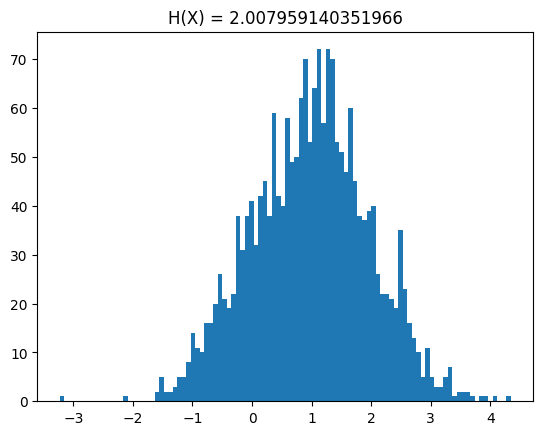

In [28]:
sample_arr = generateMixture(num_samples=[1000, 1000], means=[1, 1], stds=[1, 1])
result = calculateMixture1d(sample_arr)
_ = plt.hist(sample_arr, bins=int(100))
_ = plt.title(f"H(X) = {result.Hx}")

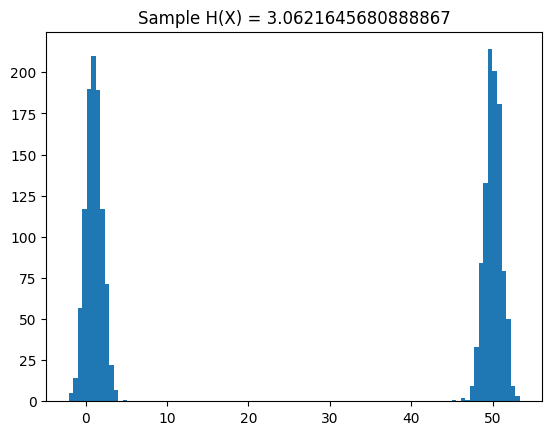

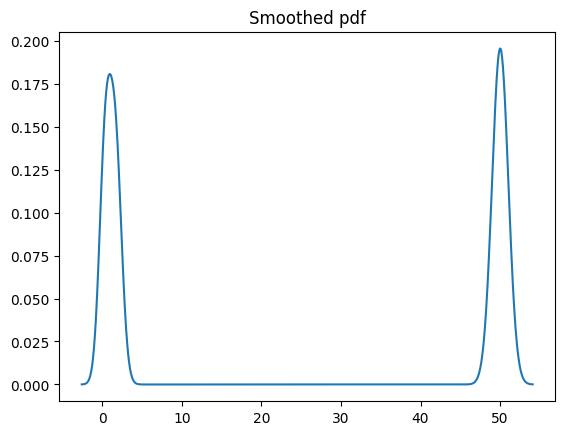

In [29]:
sample_arr = generateMixture(num_samples=[1000, 1000], means=[1, 50], stds=[1, 1])
result = calculateMixture1d(sample_arr, num_component=3)
_ = plt.hist(sample_arr, bins=int(100))
_ = plt.title(f"Sample H(X) = {result.Hx}")
plt.figure()
_ = plt.plot(result.variate_arr, result.pdf_arr)
_ = plt.title("Smoothed pdf")

In [30]:
print(f"{result.Hx}\n{result.gmm.means_}\n{result.gmm.covariances_}\n{result.gmm.weights_}")

3.0621645680888867
[[50.01981918]
 [ 1.64235663]
 [ 0.32913923]]
[[1.04171872]
 [0.62214481]
 [0.53656151]]
[0.5        0.26474426 0.23525574]


In [31]:


result1 = calculateGaussianMixtureEntropy([0], [1], [1])
result1.Hx

2.0462073369526284

Let $H_G (X;n, \mu, \sigma, \pi)$ be entropy for a guassian mixture with $n$ components and
vectors $\mu, \sigma, \pi$ as the mean, standard deviation, and weights.
Suppose that the means are separated so that $f_n (x) \approx 0$ if $x$ is in class $m \neq n$.
Let $C = \bigcup_n C_n$ be the regions over which each component is defined.
Then
\begin{eqnarray}
H_G(X; n, \mu, \sigma, \pi) & = & -\sum_n \int_C \pi_n f_n log_2 \left( \pi_n f_n (x) \right) dx \\
 & \approx &  - \sum_n \int_{C_n} \pi_n f_n(x) log_2 \left( \pi_n f_n(x) \right) dx \\
 & = & \sum_n \pi_n H_n (X) - \pi_n log_2 \pi_n \\
\end{eqnarray}

Claim. Let $f_1 = f_2$ and $\pi_1 = \pi_2 = 0.5$, 
and $f(x) = \sum_n \pi_n f_n(x)$.
Then $H(X; f_n, \pi_n) = H(X; f_1) = H(X; f_2)$.

# Multidimension gaussian mixtures

The diferential entropy of a k-dimension multivariate gaussian is
\begin{eqnarray}
h(X) & = & \frac{1}{2} log_2 \left( (2 \pi e)^k \left| \Sigma \right| \right)
\end{eqnarray}

Learned Weights:
[0.19566165 0.20006608 0.41261307 0.07725377 0.11440545]

Learned Means:
[[-2.92285213  9.10880429]
 [-6.88056555 -7.10740716]
 [ 3.41865217  3.38525658]
 [-9.8969434   9.15835074]
 [-8.75034498  6.30680079]]

Learned Covariances (first component):
[[2.79606205 0.38414604]
 [0.38414604 3.84424576]]



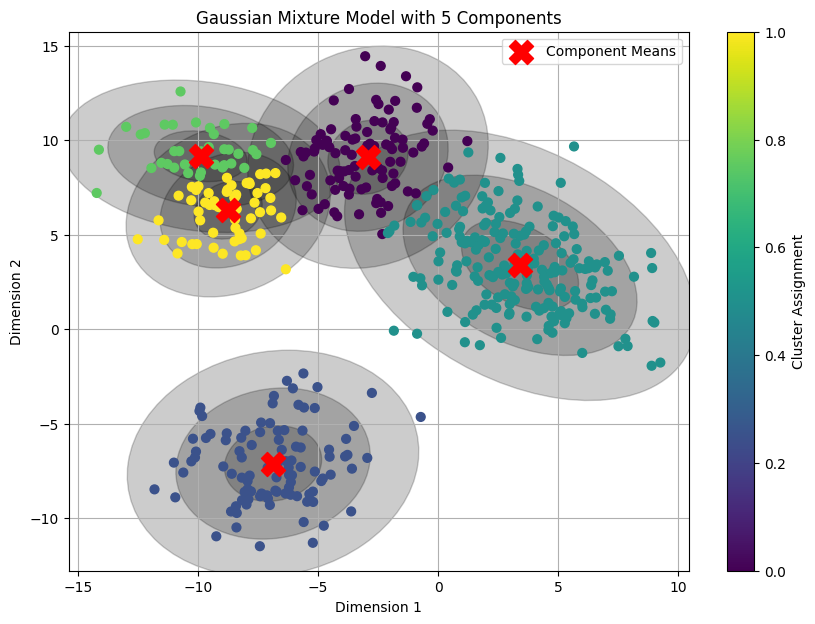

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs

NUM_COMPONENTS = 5
STD = 2.0

# 1. Generate Synthetic 2D Data
# We'll create some data that looks like it came from a few distinct Gaussian distributions
n_samples = 500
random_state = 42

# Generate isotropic Gaussian blobs for clustering
X, y_true = make_blobs(n_samples=n_samples, centers=NUM_COMPONENTS, cluster_std=STD, random_state=random_state)

# You can also create more complex data manually if needed:
# X = np.array([
#     [1, 2], [1.5, 1.8], [5, 8], [8, 8], [1, 0.6],
#     [9, 11], [8, 2], [10, 10], [1, 2], [7, 8],
#     [3, 4], [3.5, 4.2], [6, 9], [9, 9], [2, 1.2]
# ])

# 2. Define and Fit the Gaussian Mixture Model
# Let's assume we want to find 3 clusters (components)
n_components = NUM_COMPONENTS
gmm = GaussianMixture(n_components=n_components, random_state=random_state)
gmm.fit(X)

# 3. Predict Cluster Assignments
# Assign each data point to its most probable Gaussian component
labels = gmm.predict(X)

# 4. Predict Probabilities of Cluster Membership (Responsibility)
# Get the probability that each sample belongs to each component
probabilities = gmm.predict_proba(X)

# 5. Get Model Parameters
# Access the learned parameters:
weights = gmm.weights_       # Weights of each component (sum to 1)
means = gmm.means_           # Mean of each component
covariances = gmm.covariances_ # Covariance matrix of each component

print(f"Learned Weights:\n{weights}\n")
print(f"Learned Means:\n{means}\n")
# For 2D data, covariances will be 2x2 matrices
print(f"Learned Covariances (first component):\n{covariances[0]}\n")

# 6. Visualize the Results
plt.figure(figsize=(10, 7))

# Plot the data points, colored by their predicted cluster
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

# Plot the means of the Gaussian components
plt.scatter(means[:, 0], means[:, 1], s=300, c='red', marker='X', label='Component Means', zorder=3)

# Plot the ellipses representing the covariance of each component
# This part is a bit more involved, we'll draw ellipses based on means and covariances
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()

    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else: # If covariance is diagonal (spherical or diagonal covariance type)
        angle = 0
        width, height = 2 * np.sqrt(covariance)

    # Plot an ellipse to show the Gaussian component
    for nstd in range(1, 4): # Plot ellipses at 1, 2, 3 standard deviations
        ell = Ellipse(position, nstd * width, nstd * height,
                      angle=angle, **kwargs)
        ax.add_artist(ell)

ax = plt.gca()
for i in range(n_components):
    draw_ellipse(means[i], covariances[i], ax=ax, alpha=0.2, color='black')

plt.title(f'Gaussian Mixture Model with {n_components} Components')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Cluster Assignment')
plt.legend()
plt.grid(True)
plt.show()

# You can also use the model to score new data or calculate the log-likelihood
# score = gmm.score(X) # Average log-likelihood of the samples
# print(f"Average log-likelihood: {score}")

# log_likelihood_per_sample = gmm.score_samples(X)
# print(f"Log-likelihood per sample (first 5):\n{log_likelihood_per_sample[:5]}")

In [41]:
X, y_true = make_blobs(n_samples=n_samples, centers=5, cluster_std=0.8, random_state=random_state)

In [52]:
np.shape(X)

(500, 2)

In [46]:
# 3 Gausian components, each as a 2 X 2 matrix
covariances

array([[[ 0.7230933 ,  0.01532615],
        [ 0.01532615,  0.59907142]],

       [[ 0.49610205, -0.05764791],
        [-0.05764791,  0.66355257]],

       [[ 0.57683142, -0.00844872],
        [-0.00844872,  0.610668  ]]])

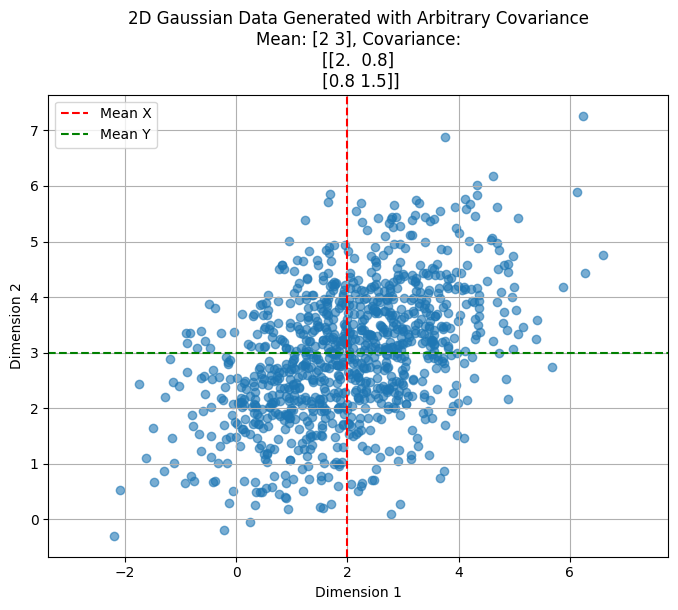

Generated Data Shape: (1000, 2)

Sample of generated data (first 5 rows):
 [[-0.89993806  3.34529659]
 [ 1.51238003  2.17128512]
 [ 3.32118864  3.36163917]
 [ 3.2650446   4.21153345]
 [ 2.46656991  3.92457334]]

Empirical Mean of Generated Data:
 [2.03000454 2.96143625]

Empirical Covariance of Generated Data:
 [[1.86238579 0.75175721]
 [0.75175721 1.40725163]]


In [62]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Define the Mean Vector (mu) for your 2D Gaussian
# This is the center of your Gaussian cloud.
mu = np.array([2, 3]) # Mean for x-dimension is 2, mean for y-dimension is 3

# 2. Define the Covariance Matrix (sigma) for your 2D Gaussian
# This matrix determines the shape, orientation, and scale of your Gaussian.
# It must be symmetric and positive semi-definite.

# Example of an arbitrary covariance matrix:
# - A large positive covariance (e.g., 2.0) along the main diagonal (variance)
# - A non-zero off-diagonal term (e.g., 0.8) indicates correlation between x and y.
#   A positive value means as x increases, y tends to increase.
sigma = np.array([
    [2.0, 0.8],  # Variance of x, Covariance(x,y)
    [0.8, 1.5]   # Covariance(y,x), Variance of y
])

# 3. Generate 2D Gaussian samples using numpy.random.multivariate_normal
num_samples = 1000
data = np.random.multivariate_normal(mu, sigma, num_samples)

# 4. Visualize the generated data
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.6)
plt.title(f'2D Gaussian Data Generated with Arbitrary Covariance\nMean: {mu}, Covariance:\n{sigma}')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.axvline(mu[0], color='red', linestyle='--', label='Mean X')
plt.axhline(mu[1], color='green', linestyle='--', label='Mean Y')
plt.axis('equal') # To correctly visualize the shape of the ellipse
plt.legend()
plt.show()

print("Generated Data Shape:", data.shape)
print("\nSample of generated data (first 5 rows):\n", data[:5])
print("\nEmpirical Mean of Generated Data:\n", np.mean(data, axis=0))
print("\nEmpirical Covariance of Generated Data:\n", np.cov(data, rowvar=False))